# DBSCAN

## Spherical Data

Sample dataset with 2000 points:

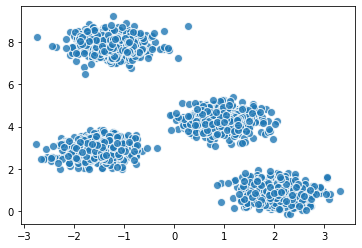

In [ ]:
import numpy as np
from sklearn import datasets

N_samples = 2000

dataset_1 = np.array(datasets.make_blobs(n_samples=N_samples,
  centers=4, cluster_std=0.4, random_state=0)[0])

import matplotlib.pyplot as plt

plt.scatter(dataset_1[:,0], dataset_1[:,1],
            alpha=0.8, s=64, edgecolors='white')
plt.show()



We apply DBSCAN to visualize the detected groups:

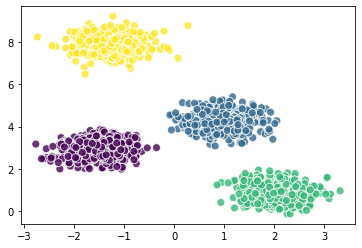

In [ ]:
from sklearn.cluster import DBSCAN

dbs_1 = DBSCAN(eps=0.7)
labels_1 = dbs_1.fit(dataset_1).labels_ 

plt.scatter(dataset_1[:,0], dataset_1[:,1], c=labels_1,
                   alpha=0.8, s=64, edgecolors='white')
plt.show()

There are several points not connected to any other set of points that are labeled as noise points.

To confirm this, we list the labels it has generated:

In [ ]:
np.unique(labels_1)

array([0, 1, 2, 3])

And we can see how the `noise`(-1) tag is present.

## Non-Spherical Data

Now we are going to distribute the points in concentric rings.

This is a rather tricky problem because the clusters represented are not spherical:

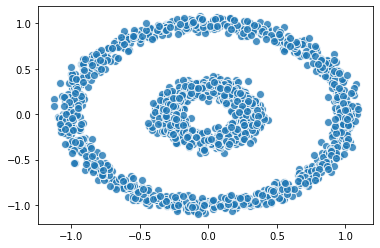

In [ ]:
import numpy as np
from sklearn import datasets

N_samples = 2000

dataset_2 = np.array(datasets.make_circles(n_samples=N_samples,
  noise=0.05, factor=0.3)[0])

import matplotlib.pyplot as plt

plt.scatter(dataset_2[:,0], dataset_2[:,1],
            alpha=0.8, s=64, edgecolors='white')
plt.show()

and use DBSCAN:

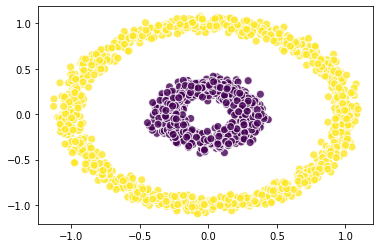

In [ ]:
from sklearn.cluster import DBSCAN

dbs_2 = DBSCAN(eps=0.25)
labels_2 = dbs_2.fit(dataset_2).labels_ 

plt.scatter(dataset_2[:,0], dataset_2[:,1], c=labels_2,
                   alpha=0.8, s=64, edgecolors='white')
plt.show()

Now the result is perfect. No point has been classified as a noise point, there are only two labels:

In [ ]:
np.unique(labels_2)

array([0, 1])

## Implementation

Source code available at [GitHub](https://github.com/chrisjmccormick/dbscan)

### Area

We first implement the function that returns the neighbors to a point $𝑝$ that is distance less than $𝑒𝑝𝑠$ :


In [ ]:
import numpy as np

def regionQuery(D, P, eps):
    """
    Find all points in dataset `D` within distance `eps` of point `P`.
    
    This function calculates the distance between a point P and every other 
    point in the dataset, and then returns only those points which are within a
    threshold distance `eps`.
    """
    neighbors = []
    
    # For each point in the dataset...
    for Pn in range(0, len(D)):
        
        # If the distance is below the threshold, add it to the neighbors list.
        if np.linalg.norm(D[P] - D[Pn]) < eps:
           neighbors.append(Pn)
            
    return neighbors

### Group

Given a seed, $𝑝$ , construct the group from the points in the dataset that are less than $𝑒𝑝𝑠$ away from $𝑝$ and, provided that, there are at least $𝑀𝑖𝑛𝑃𝑡𝑠$ points:


In [ ]:
def growCluster(D, labels, P, NeighborPts, C, eps, MinPts):
    """
    Grow a new cluster with label `C` from the seed point `P`.
    
    This function searches through the dataset to find all points that belong
    to this new cluster. When this function returns, cluster `C` is complete.
    
    Parameters:
      `D`      - The dataset (a list of vectors)
      `labels` - List storing the cluster labels for all dataset points
      `P`      - Index of the seed point for this new cluster
      `NeighborPts` - All of the neighbors of `P`
      `C`      - The label for this new cluster.  
      `eps`    - Threshold distance
      `MinPts` - Minimum required number of neighbors
    """

    # Assign the cluster label to the seed point.
    labels[P] = C
    
    # Look at each neighbor of P (neighbors are referred to as Pn). 
    # NeighborPts will be used as a FIFO queue of points to search--that is, it
    # will grow as we discover new branch points for the cluster. The FIFO
    # behavior is accomplished by using a while-loop rather than a for-loop.
    # In NeighborPts, the points are represented by their index in the original
    # dataset.
    i = 0
    while i < len(NeighborPts):    
        
        # Get the next point from the queue.        
        Pn = NeighborPts[i]
       
        # If Pn was labelled NOISE during the seed search, then we
        # know it's not a branch point (it doesn't have enough neighbors), so
        # make it a leaf point of cluster C and move on.
        if labels[Pn] == -1:
           labels[Pn] = C
        
        # Otherwise, if Pn isn't already claimed, claim it as part of C.
        elif labels[Pn] == 0:
            # Add Pn to cluster C (Assign cluster label C).
            labels[Pn] = C
            
            # Find all the neighbors of Pn
            PnNeighborPts = regionQuery(D, Pn, eps)
            
            # If Pn has at least MinPts neighbors, it's a branch point!
            # Add all of its neighbors to the FIFO queue to be searched. 
            if len(PnNeighborPts) >= MinPts:
                NeighborPts = NeighborPts + PnNeighborPts
            # If Pn *doesn't* have enough neighbors, then it's a leaf point.
            # Don't queue up it's neighbors as expansion points.
            #else:
                # Do nothing                
                #NeighborPts = NeighborPts               
        
        # Advance to the next point in the FIFO queue.
        i += 1        
    
    # We've finished growing cluster C!

Now we can iterate starting from any point in the data set to identify the groups:

In [ ]:
import tqdm
import time

def MyDBSCAN(D, eps, MinPts):
    """
    Cluster the dataset `D` using the DBSCAN algorithm.
    
    MyDBSCAN takes a dataset `D` (a list of vectors), a threshold distance
    `eps`, and a required number of points `MinPts`.
    
    It will return a list of cluster labels. The label -1 means noise, and then
    the clusters are numbered starting from 1.
    """
 
    # This list will hold the final cluster assignment for each point in D.
    # There are two reserved values:
    #    -1 - Indicates a noise point
    #     0 - Means the point hasn't been considered yet.
    # Initially all labels are 0.    
    labels = [0]*len(D)

    # C is the ID of the current cluster.    
    C = 0
    
    # This outer loop is just responsible for picking new seed points--a point
    # from which to grow a new cluster.
    # Once a valid seed point is found, a new cluster is created, and the 
    # cluster growth is all handled by the 'expandCluster' routine.
    
    # For each point P in the Dataset D...
    # ('P' is the index of the datapoint, rather than the datapoint itself.)
    for P in tqdm.tqdm(range(0, len(D))):
    
        # Only points that have not already been claimed can be picked as new 
        # seed points.    
        # If the point's label is not 0, continue to the next point.
        if not (labels[P] == 0):
           continue
        
        # Find all of P's neighboring points.
        NeighborPts = regionQuery(D, P, eps)
        
        # If the number is below MinPts, this point is noise. 
        # This is the only condition under which a point is labeled 
        # NOISE--when it's not a valid seed point. A NOISE point may later 
        # be picked up by another cluster as a boundary point (this is the only
        # condition under which a cluster label can change--from NOISE to 
        # something else).
        if len(NeighborPts) < MinPts:
            labels[P] = -1
        # Otherwise, if there are at least MinPts nearby, use this point as the 
        # seed for a new cluster.    
        else: 
           C += 1
           growCluster(D, labels, P, NeighborPts, C, eps, MinPts)
    
    # All data has been clustered!
    return labels

### Test

Let's test it with the same non-spherical data set:

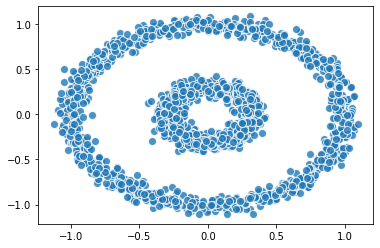

In [ ]:
from sklearn import datasets

N_samples = 2000

dataset_3 = np.array(datasets.make_circles(n_samples=N_samples,
  noise=0.05, factor=0.3)[0])

import matplotlib.pyplot as plt

plt.scatter(dataset_3[:,0], dataset_3[:,1],
            alpha=0.8, s=64, edgecolors='white')
plt.show()

We launch our own DBSCAN:

100%|██████████| 2000/2000 [00:34<00:00, 57.92it/s]


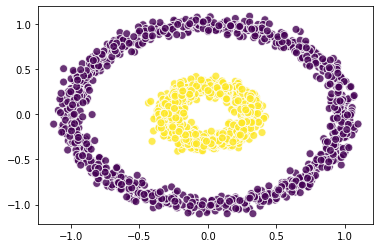

In [ ]:
my_labels = MyDBSCAN(dataset_3, eps=0.3, MinPts=10)
plt.scatter(dataset_3[:,0], dataset_3[:,1], c=my_labels,
                   alpha=0.8, s=64, edgecolors='white')
plt.show()